# Fake news classification
Julio César Briones Wong

A00838831

## Preparing the data

### Libraries

In [1]:
!pip install tensorflow==2.12.0

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import TextVectorization

### Importing the dataset

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

df_true = pd.read_csv(path + "/True.csv")
df_fake = pd.read_csv(path + "/Fake.csv")
df_true['label'] = 1
df_fake['label'] = 0

df = pd.concat([df_true, df_fake], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head(10)

,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0
5,"As private lawyer, Trump high court pick was f...",WASHINGTON (Reuters) - As a lawyer in private ...,politicsNews,"February 1, 2017",1
6,Yemeni Salafist imam killed in Aden: sources,ADEN (Reuters) - A Salafist imam was shot dead...,worldnews,"October 28, 2017",1
7,FBI says witnesses in U.S. probe into Malaysia...,KUALA LUMPUR (Reuters) - Potential witnesses t...,worldnews,"September 6, 2017",1
8,An Easy To Read Chart Shows How Bernie Sanders...,The goal of socialism is communism. -Vladimi...,politics,"Feb 24, 2016",0
9,MMA FIGHTER JAKE SHIELDS Embarrasses Cowards I...,Opposing views and beliefs has much of this co...,politics,"Feb 4, 2017",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [5]:
df.describe()

,label
count,44898.000000
mean,0.477015
std,0.499477
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### Preprocessing

In [6]:
# Split the dataset into train and test sets
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df['title'], df['label'], test_size=0.2, random_state=42)

### Vectorizing

In [7]:
# Define parameters for the vectorizer
vocab_size = 42626       # Maximum vocabulary size
sequence_length = 26    # Maximum sequence length (adjust based on distribution)

# Create the TextVectorization layer
vectorizer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length,
    standardize='lower_and_strip_punctuation',
    dtype="string"
)

# Fit the vectorizer on the training text
vectorizer.adapt(X_train_text)

# Vectorize training and testing text
X_train = vectorizer(X_train_text)
X_test = vectorizer(X_test_text)

### Best values for vocab_size

In [8]:
vocab = vectorizer.get_vocabulary()
print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 29338


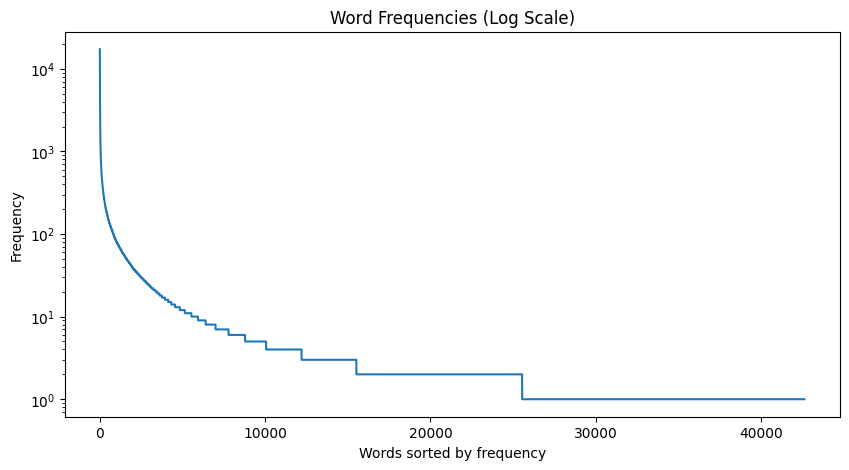

In [9]:
from collections import Counter

all_words = ' '.join(df['title']).lower().split()
word_counts = Counter(all_words)
word_freqs = list(word_counts.values())

plt.figure(figsize=(10,5))
plt.plot(np.sort(word_freqs)[::-1])
plt.yscale('log')
plt.title('Word Frequencies (Log Scale)')
plt.xlabel('Words sorted by frequency')
plt.ylabel('Frequency')
plt.show()

In [10]:
from collections import Counter

# Join all texts into a single string, then split into words
all_words = ' '.join(df['title'].values).lower().split()
word_counts = Counter(all_words)

# Print some stats
print(f"Unique words: {len(word_counts)}")
print("Top 20 most common words:")
print(word_counts.most_common(20))

Unique words: 42626
Top 20 most common words:
[('to', 17241), ('trump', 11016), ('in', 9084), ('of', 8150), ('for', 7563), ('on', 6927), ('the', 6521), ('[video]', 5054), ('u.s.', 4315), ('and', 4089), ('a', 4038), ('with', 3931), ('says', 3492), ('is', 3165), ('after', 2552), ('(video)', 2543), ('at', 2246), ('obama', 2161), ('as', 2057), ('from', 1982)]


### Best value for sequence_length

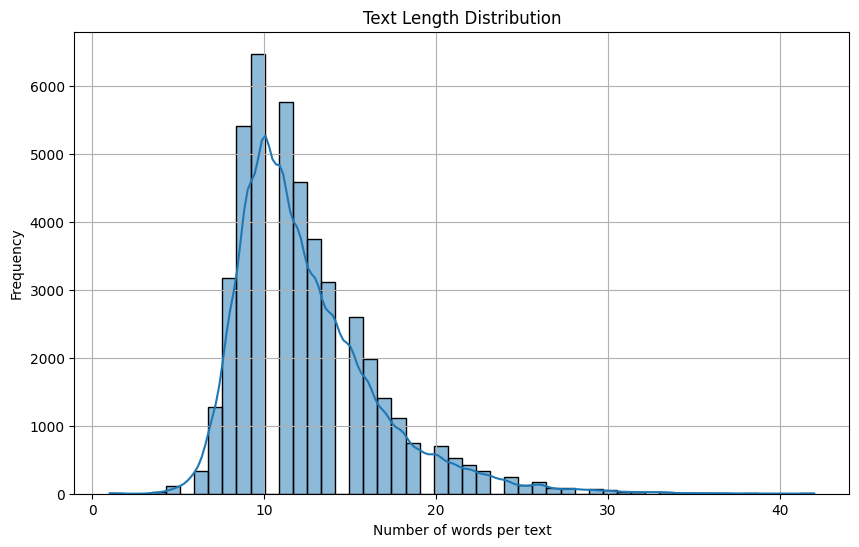

In [11]:
sequence_lengths = df['title'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
sns.histplot(sequence_lengths, bins=50, kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Number of words per text")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [12]:
percentiles = sequence_lengths.quantile([0.80, 0.90, 0.95, 0.99])
print(percentiles)

0.80    15.0
0.90    18.0
0.95    20.0
0.99    26.0
Name: title, dtype: float64


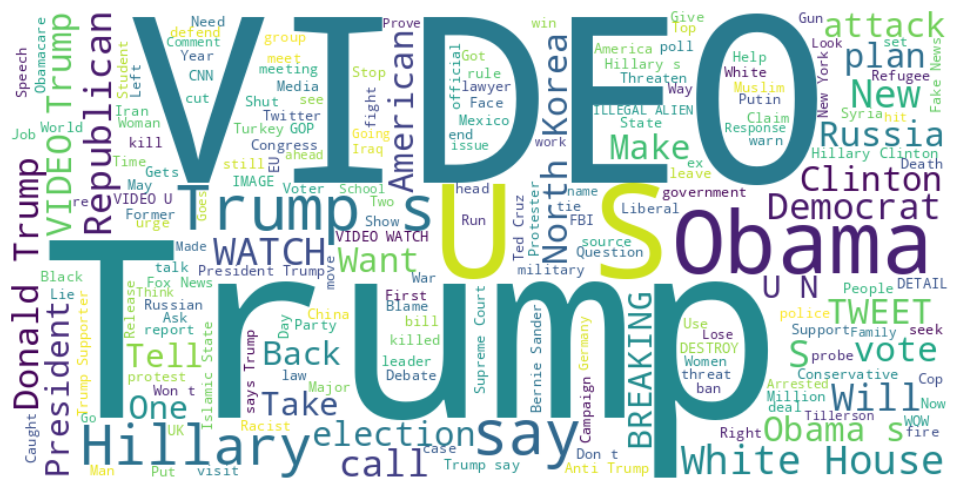

In [14]:
from wordcloud import WordCloud

# Unir todos los textos
text_all = " ".join(df['title'].astype(str))

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_all)

# Guardar como imagen
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.savefig("wordcloud.png")


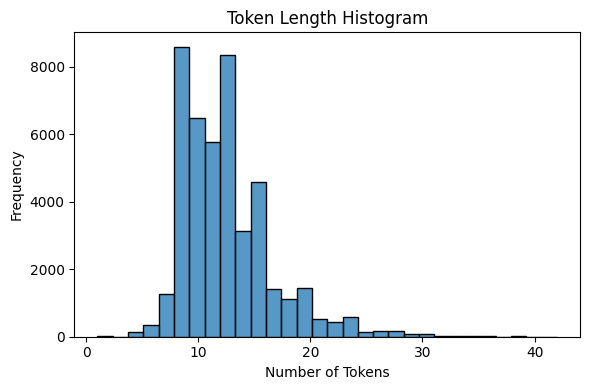

In [15]:
df['token_length'] = df['title'].apply(lambda x: len(str(x).split()))

# Generar el histograma
plt.figure(figsize=(6,4))
sns.histplot(df['token_length'], bins=30)
plt.title("Token Length Histogram")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("token_length_hist.png")

## Encoder Transformer

### Declaring the model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Positional encoding layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super().__init__()
        pos = tf.range(sequence_length)[:, tf.newaxis]                  # (seq, 1)
        i = tf.range(d_model)[tf.newaxis, :]                            # (1, d_model)
        i = tf.cast(i, tf.float32)
        pos = tf.cast(pos, tf.float32)

        angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        angle_rads = pos * angle_rates  # (seq_len, d_model)

        # Apply sin to even indices in the array; 2i
        sin_encoding = tf.math.sin(angle_rads[:, 0::2])

        # Apply cos to odd indices in the array; 2i+1
        cos_encoding = tf.math.cos(angle_rads[:, 1::2])

        # Interleave sin and cos
        pos_encoding = tf.reshape(
            tf.stack([sin_encoding, cos_encoding], axis=-1),
            shape=(sequence_length, d_model)
        )

        self.pos_encoding = pos_encoding[tf.newaxis, ...]

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# Hyperparameters
embedding_dim = 128
num_heads = 4
ff_dim = 128
dropout_rate = 0.1

# Input layer
inputs = layers.Input(shape=(sequence_length,))

# Embedding + Positional Encoding
x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
x = PositionalEncoding(sequence_length, embedding_dim)(x)

# Multi-head self-attention + residual connection
attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
x = layers.Add()([x, attn_output])
x = layers.LayerNormalization(epsilon=1e-6)(x)

# Feedforward layer + residual connection
ffn = layers.Dense(ff_dim, activation='relu')(x)
ffn = layers.Dense(embedding_dim)(ffn)
x = layers.Add()([x, ffn])
x = layers.LayerNormalization(epsilon=1e-6)(x)
x = layers.Dropout(dropout_rate)(x)

# Global pooling and classification head
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(dropout_rate)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

# Compile model
model = models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 26)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 26, 128)      5456128     ['input_1[0][0]']                
                                                                                                  
 positional_encoding (Positiona  (None, 26, 128)     0           ['embedding[0][0]']              
 lEncoding)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 26, 128)     263808      ['positional_encoding[0][0]',

### Training

In [ ]:
history = model.fit(X_train, y_train, epochs=1, batch_size=64, validation_split=0.1)

### Evaluating

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_model(model, X_test, y_test):
    # Generate predicted probabilities
    y_pred_prob = model.predict(X_test)

    # Convert probabilities to binary predictions (threshold = 0.5)
    y_pred = (y_pred_prob > 0.5).astype("int32")

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy: {acc:.4f}")

    # Classification report (precision, recall, F1)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


In [ ]:
evaluate_model(model, X_test, y_test)

### Hyperparameter tunning

In [19]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 24.5 MB/s eta 0:00:00


In [16]:
from tensorflow.keras import layers, models
import tensorflow as tf

def build_transformer_model(sequence_length, vocab_size, embedding_dim, num_heads, ff_dim, dropout_rate):
    inputs = layers.Input(shape=(sequence_length,))

    # Embedding layer (word embeddings)
    x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)

    # Positional encoding (learned positional embeddings)
    position_ids = tf.range(start=0, limit=sequence_length, delta=1)
    position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embedding_dim)(position_ids)
    x = x + position_embeddings

    # Transformer encoder block
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization()(x)

    ffn_output = layers.Dense(ff_dim, activation="relu")(x)
    ffn_output = layers.Dense(embedding_dim)(ffn_output)
    x = layers.Add()([x, ffn_output])
    x = layers.LayerNormalization()(x)

    # Pooling and classification head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [17]:
def objective(trial):
    # Hyperparams a buscar
    embedding_dim = trial.suggest_categorical("embedding_dim", [64, 128])
    num_heads = trial.suggest_categorical("num_heads", [2, 4])
    ff_dim = trial.suggest_categorical("ff_dim", [64, 128, 256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3,log=True)

    # Crear modelo Transformer usando estos valores
    model = build_transformer_model(sequence_length, vocab_size, embedding_dim, num_heads, ff_dim, dropout_rate)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Entrenamiento rápido (e.g., 3 epochs)
    history = model.fit(X_train, y_train, validation_split=0.1, batch_size=64, epochs=3, verbose=0)
    val_acc = history.history["val_accuracy"][-1]

    return val_acc

In [21]:
import optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3)
# Historial de optimización
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig("optuna_optimization_history.png")
plt.close()

# Importancia de hiperparámetros
optuna.visualization.matplotlib.plot_param_importances(study)
plt.savefig("optuna_param_importances.png")
plt.close()
print("Mejores hiperparámetros:")
print(study.best_params)

[I 2025-06-18 04:40:47,131] A new study created in memory with name: no-name-4260117a-2ccb-4099-8b15-1075cd8ec5be
[I 2025-06-18 04:43:14,365] Trial 0 finished with value: 0.9688196182250977 and parameters: {'embedding_dim': 64, 'num_heads': 2, 'ff_dim': 256, 'dropout_rate': 0.41258640598793883, 'learning_rate': 0.0007328289178150055}. Best is trial 0 with value: 0.9688196182250977.
[I 2025-06-18 04:47:39,202] Trial 1 finished with value: 0.967706024646759 and parameters: {'embedding_dim': 128, 'num_heads': 4, 'ff_dim': 128, 'dropout_rate': 0.3642740657373976, 'learning_rate': 6.19468846401819e-05}. Best is trial 0 with value: 0.9688196182250977.
[I 2025-06-18 04:51:03,435] Trial 2 finished with value: 0.9710467457771301 and parameters: {'embedding_dim': 128, 'num_heads': 2, 'ff_dim': 256, 'dropout_rate': 0.2567578921973217, 'learning_rate': 0.0001090562820294498}. Best is trial 2 with value: 0.9710467457771301.
<ipython-input-21-3110813970>:5: ExperimentalWarning: plot_optimization_his

Mejores hiperparámetros:
{'embedding_dim': 128, 'num_heads': 2, 'ff_dim': 256, 'dropout_rate': 0.2567578921973217, 'learning_rate': 0.0001090562820294498}


In [ ]:
transformer = build_transformer_model(sequence_length,vocab_size,64,2,128,0.29828453441887093)
transformer.summary()
transformer.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2.174068079102265e-05),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
transformer.fit(X_train, y_train, validation_split=0.1, batch_size = 64, epochs=3)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 26)]         0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 26, 64)       2728064     ['input_4[0][0]']                
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 26, 64)      0           ['embedding_5[0][0]']            
 mbda)                                                                                            
                                                                                                  
 multi_head_attention_3 (MultiH  (None, 26, 64)      33216       ['tf.__operators__.add_2[0]

281/281 [==============================] - 3s 10ms/step

Accuracy: 0.9422

Classification Report:
              precision    recall  f1-score   support

        Fake       0.95      0.94      0.94      4669
        Real       0.94      0.94      0.94      4311

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



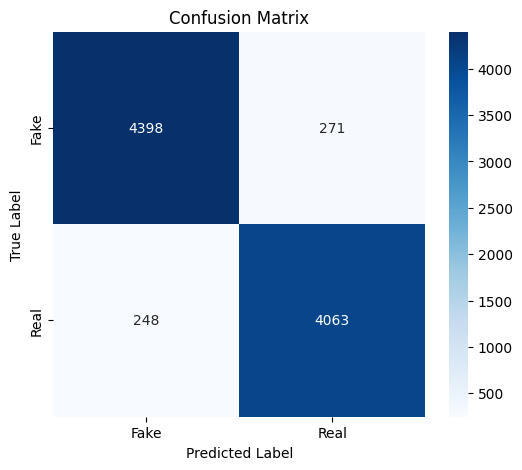

In [ ]:
evaluate_model(transformer, X_test, y_test)

## BiLSTM Model

### Declaring the model

In [ ]:
from tensorflow.keras import layers, models

# Parámetros
embedding_dim = 128
lstm_units = 64
dropout_rate = 0.2

# Arquitectura del modelo
inputs = layers.Input(shape=(sequence_length,))
x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=False))(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(dropout_rate)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

# Compilación
bilstm_model = models.Model(inputs, outputs)
bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Resumen
bilstm_model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_23 (Embedding)        │ (None, 26, 128)        │     5,456,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,563,265 (21.22 MB)

 Trainable params: 5,563,265 (21.22 MB)

 Non-trainable params: 0 (0.00 B)

### Training

In [ ]:
history_bilstm = bilstm_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=5,
    batch_size=64
)

Epoch 1/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.8964 - loss: 0.2520 - val_accuracy: 0.9747 - val_loss: 0.0678
Epoch 2/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.9905 - loss: 0.0301 - val_accuracy: 0.9697 - val_loss: 0.0808
Epoch 3/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9976 - loss: 0.0084 - val_accuracy: 0.9733 - val_loss: 0.0924
Epoch 4/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9990 - loss: 0.0040 - val_accuracy: 0.9697 - val_loss: 0.1125
Epoch 5/5
506/506 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9989 - loss: 0.0035 - val_accuracy: 0.9694 - val_loss: 0.1588


### Evaluating

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Accuracy: 0.9695

Classification Report:
              precision    recall  f1-score   support

        Fake       0.97      0.98      0.97      4669
        Real       0.97      0.96      0.97      4311

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980



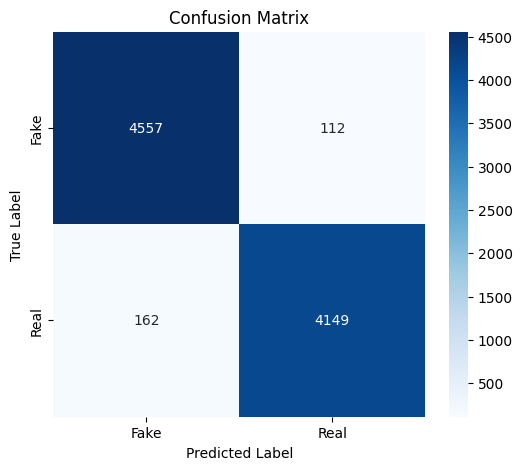

In [ ]:
evaluate_model(bilstm_model,X_test, y_test)

## RoBERTa model

In [ ]:
!pip install -q transformers datasets

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# Load tokenizer and model
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

# Cargar modelo y tokenizer más ligero
model_name = "distilroberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
roberta_model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)



In [ ]:
def tokenize_texts(texts, tokenizer, max_length=512):
    return tokenizer(
        list(texts),
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="tf"
    )

# Tokenize your sets
X_train_tok = tokenize_texts(X_train_text, tokenizer, max_length=512)
X_test_tok = tokenize_texts(X_test_text, tokenizer, max_length=512)


In [ ]:
# Convert y values to tensors
import tensorflow as tf
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

from transformers import create_optimizer

batch_size = 16
steps_per_epoch = len(X_train) // batch_size
num_train_steps = steps_per_epoch * 3
num_warmup_steps = num_train_steps // 10

optimizer, lr_schedule = create_optimizer(
    init_lr=5e-5,
    num_warmup_steps=num_warmup_steps,
    num_train_steps=num_train_steps
)

roberta_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

roberta_model.fit(
    X_train_tok.data,
    y_train_tf,
    validation_split=0.1,
    epochs=5,
    batch_size=batch_size
)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.special import softmax

def evaluate_roberta(model, X_tok, y_true, threshold=0.5):
    """
    Evaluates a RoBERTa-based classification model using tokenized input.

    Parameters:
    - model: Hugging Face model (TFAutoModelForSequenceClassification)
    - X_tok: tokenized inputs (output of tokenizer(..., return_tensors="tf"))
    - y_true: true labels (array-like)
    - threshold: probability threshold for binary classification

    Prints metrics and shows confusion matrix.
    """
    # Get raw logits from the model
    logits = model.predict(X_tok.data).logits

    # Apply softmax to get probabilities
    probs = softmax(logits, axis=1)
    y_pred = (probs[:, 1] > threshold).astype("int32")  # Prob of class 1 ("real")

    # Metrics
    print(f"\nAccuracy: {accuracy_score(y_true, y_pred):.4f}\n")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Fake", "Real"]))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
evaluate_roberta(roberta_model, X_test_tok, y_test)

In [ ]:
# Etiquetas balanceadas
print("Train labels:", np.bincount(y_train))
print("Test labels:", np.bincount(y_test))

# Verifica etiquetas únicas
print("Unique y_train:", np.unique(y_train))

## Function with external texts

In [ ]:
def predict_news(text, model, vectorizer, threshold=0.5):
    """
    Predicts whether a news article is fake or real.

    Parameters:
    - text (str): the input news article
    - model (tf.keras.Model): the trained classification model
    - vectorizer (TextVectorization): the fitted vectorizer used during training
    - threshold (float): probability threshold to decide class

    Returns:
    - prediction_label (str): "Real" or "Fake"
    - probability (float): predicted probability of class 1 (real)
    """
    import numpy as np

    # Create batch of one
    text_tensor = tf.convert_to_tensor([text])

    # Tokenize and pad
    vectorized_input = vectorizer(text_tensor)

    # Predict
    prob = model.predict(vectorized_input)[0][0]
    label = "Real" if prob > threshold else "Fake"

    print(f"Prediction: {label} (probability: {prob:.4f})")
    return label, prob

In [ ]:
sample_news = "2011 via CQ subscribers only Tax Foundation"

predict_news(sample_news, model=transformer, vectorizer=vectorizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
Prediction: Real (probability: 0.9318)


('Real', np.float32(0.9318354))

## Saving models

In [ ]:
transformer.save("modelo_transformer.h5",include_optimizer=False)

In [ ]:
bilstm_model.save("modelo_bilstm.keras")

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Empaqueta el vectorizador en un modelo funcional
input_layer = Input(shape=(1,), dtype="string")
vectorizer_model = Model(inputs=input_layer, outputs=vectorizer(input_layer))

# Guarda el modelo que contiene al vectorizador
vectorizer_model.save("vectorizer.keras", include_optimizer=False)

NotImplementedError: Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, use `save_format='tf'` instead. Received a model or layer TextVectorization with weights [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x793bc477d690>]

In [ ]:
vectorizer_model.save("vectorizer", save_format="tf", include_optimizer=False)
